# Scalable Additive-Structure GP Classification (CUDA) (w/ KISS-GP)

## Introduction

This example shows how to use a `AdditiveGridInducingVariationalGP` module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension. This is equivalent to using a covariance function that additively decomposes over dimensions:

$$k(\mathbf{x},\mathbf{x'}) = \sum_{i=1}^{d}k([\mathbf{x}]_{i}, [\mathbf{x'}]_{i})$$

where $[\mathbf{x}]_{i}$ denotes the ith component of the vector $\mathbf{x}$. Example applications of this include use in Bayesian optimization, and when performing deep kernel learning. 

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic in the number of data points.


In this example, we’re performing classification on a two dimensional toy dataset that is:
- Defined in [-1, 1]x[-1, 1]
- Valued 1 in [-0.5, 0.5]x[-0.5, 0.5]
- Valued -1 otherwise

The above function doesn't have an obvious additive decomposition, but it turns out that this function is can be very well approximated by the kernel anyways.

In [1]:
# High-level imports
import math
from math import exp
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make inline plots
%matplotlib inline

## Generate toy dataset

In [2]:
n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1

train_x = train_x.cuda()
train_y = train_y.cuda()

## Define the model

In contrast to the most basic classification models, this model uses an `AdditiveGridInterpolationVariationalStrategy`. This causes two key changes in the model. First, the model now specifically assumes that the input to `forward`, `x`, is to be additive decomposed. Thus, although the model below defines an `RBFKernel` as the covariance function, because we extend this base class, the additive decomposition discussed above will be imposed. 

Second, this model automatically assumes we will be using scalable kernel interpolation (SKI) for each dimension. Because of the additive decomposition, we only provide one set of grid bounds to the base class constructor, as the same grid will be used for all dimensions. It is recommended that you scale your training and test data appropriately.

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import AdditiveGridInterpolationVariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.means import ConstantMean
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.distributions import MultivariateNormal

class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=16, grid_bounds=([-1, 1],)):
        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=16, batch_size=2)
        variational_strategy = AdditiveGridInterpolationVariationalStrategy(self,
                                                                            grid_size=grid_size,
                                                                            grid_bounds=grid_bounds,
                                                                            num_dim=2,
                                                                            variational_distribution=variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-1e-5, 1e-5))
        self.covar_module = ScaleKernel(
            RBFKernel(
                ard_num_dims=1, log_lengthscale_prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True)
            ),
            log_outputscale_prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = MultivariateNormal(mean_x, covar_x)
        return latent_pred

# Cuda the model and likelihood function
model = GPClassificationModel().cuda()
likelihood = gpytorch.likelihoods.BernoulliLikelihood().cuda()

## Training the model

Once the model has been defined, the training loop looks very similar to other variational models we've seen in the past. We will optimize the variational lower bound as our objective function. In this case, although variational inference in GPyTorch supports stochastic gradient descent, we choose to do batch optimization due to the relatively small toy dataset.

For an example of using the `AdditiveGridInducingVariationalGP` model with stochastic gradient descent, see the `dkl_mnist` example.

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_y))

# Training function
def train():
    num_iter = 25
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()

# Sometimes we get better performance on the GPU when we don't use Toeplitz math
# for SKI. This flag controls that
with gpytorch.settings.use_toeplitz(False):
    %time train()

Iter 1/25 - Loss: 1.268
Iter 2/25 - Loss: 1.103
Iter 3/25 - Loss: 1.261
Iter 4/25 - Loss: 0.759
Iter 5/25 - Loss: 0.931
Iter 6/25 - Loss: 0.761
Iter 7/25 - Loss: 0.484
Iter 8/25 - Loss: 0.484
Iter 9/25 - Loss: 0.446
Iter 10/25 - Loss: 0.391
Iter 11/25 - Loss: 0.391
Iter 12/25 - Loss: 0.360
Iter 13/25 - Loss: 0.461
Iter 14/25 - Loss: 0.325
Iter 15/25 - Loss: 0.318
Iter 16/25 - Loss: 0.299
Iter 17/25 - Loss: 0.246
Iter 18/25 - Loss: 0.216
Iter 19/25 - Loss: 0.253
Iter 20/25 - Loss: 0.231
Iter 21/25 - Loss: 0.212
Iter 22/25 - Loss: 0.218
Iter 23/25 - Loss: 0.220
Iter 24/25 - Loss: 0.203
Iter 25/25 - Loss: 0.183
CPU times: user 17.4 s, sys: 1.17 s, total: 18.6 s
Wall time: 18.6 s


## Test the model

Next we test the model and plot the decision boundary. Despite the function we are optimizing not having an obvious additive decomposition, the model provides accurate results.

(-0.5, 1.5)

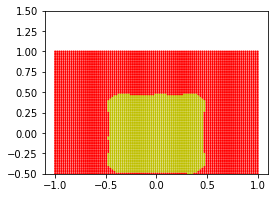

In [5]:
# Switch the model and likelihood into the evaluation mode
model.eval()
likelihood.eval()

# Start the plot, 4x3in
f, ax = plt.subplots(1, 1, figsize=(4, 3))

n = 100
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
# Cuda variable of test data
test_x = test_x.cuda()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False):
    predictions = likelihood(model(test_x))

# prob<0.5 --> label -1 // prob>0.5 --> label 1
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1).cpu()
# Colors = yellow for 1, red for -1
color = []
for i in range(len(pred_labels)):
    if pred_labels[i] == 1:
        color.append('y')
    else:
        color.append('r')
        
# Plot data a scatter plot
ax.scatter(test_x[:, 0].cpu(), test_x[:, 1].cpu(), color=color, s=1)
ax.set_ylim([-0.5, 1.5])